In [1]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
from graphviz import Digraph
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
df = pd.read_csv(
    "data.csv", sep=";"
)

In [3]:
df

,transaction_date,client_id,volume
0,ноябрь 2023,id00001,"7,78"
1,сентябрь 2023,id00002,"1,08"
2,февраль 2022,id00003,"39,19"
3,август 2023,id00004,"1,17"
4,сентябрь 2022,id00005,"2,07"
...,...,...,...
367420,январь 2024,id05028,"1,17"
367421,сентябрь 2023,id10204,"1,51"
367422,август 2023,id22943,"2,16"
367423,апрель 2022,id48123,"0,15"


In [4]:
months = {
    "январь": "01",
    "февраль": "02",
    "март": "03",
    "апрель": "04",
    "май": "05",
    "июнь": "06",
    "июль": "07",
    "август": "08",
    "сентябрь": "09",
    "октябрь": "10",
    "ноябрь": "11",
    "декабрь": "12",
}


def format_date(row):
    for rus, eng in months.items():
        if rus in row:
            return row.replace(rus, eng) + "-01"


df["transaction_date"] = df["transaction_date"].apply(format_date)
df["transaction_date"] = pd.to_datetime(df["transaction_date"], format="%m %Y-%d")

print(df)

       transaction_date client_id volume
0            2023-11-01   id00001   7,78
1            2023-09-01   id00002   1,08
2            2022-02-01   id00003  39,19
3            2023-08-01   id00004   1,17
4            2022-09-01   id00005   2,07
...                 ...       ...    ...
367420       2024-01-01   id05028   1,17
367421       2023-09-01   id10204   1,51
367422       2023-08-01   id22943   2,16
367423       2022-04-01   id48123   0,15
367424       2023-03-01   id32043   2,23

[367425 rows x 3 columns]


In [5]:
def classify_customers(df: pd.DataFrame):
    df.sort_values("transaction_date", inplace=True)
    df["transaction_date"] = pd.to_datetime(df["transaction_date"])

    monthly_activity = df.groupby(
        [df["client_id"], df["transaction_date"].dt.to_period("M")]
    ).size()

    customer_classifications = defaultdict(lambda: defaultdict(str))

    for (client_id, month), count in monthly_activity.items():
        previous_month = (month - 1).asfreq("M")

        previous_status = customer_classifications[client_id][previous_month]

        if count > 0:
            if previous_status == "":
                current_status = "новые/возвращенные"
            elif previous_status in ["новые/возвращенные", "постоянные"]:
                current_status = "постоянные"
            else:
                current_status = "нерегулярные"
        else:
            if previous_status in ["постоянные", "нерегулярные"]:
                current_status = "неактивные"
            else:
                current_status = previous_status

        customer_classifications[client_id][month] = current_status

    classification_df = pd.DataFrame.from_dict(
        {
            (i, j): customer_classifications[i][j]
            for i in customer_classifications.keys()
            for j in customer_classifications[i].keys()
        },
        orient="index",
    )

    classification_df.index = pd.MultiIndex.from_tuples(classification_df.index)
    classification_df.index.names = ["client_id", "month"]
    classification_df.columns = ["status"]

    return classification_df

In [6]:
def classify_transition_states(classified_data: pd.DataFrame):
    detailed_classifications = defaultdict(dict)

    for client_id, data in classified_data.groupby(level=0):
        sorted_months = sorted(data.index.get_level_values(1))
        previous_status = None

        for month in sorted_months:
            current_status = data.loc[(client_id, month), "status"]

            if previous_status:
                if current_status == "постоянные":
                    if previous_status in ["постоянные"]:
                        detailed_status = "постоянные"
                    elif previous_status in ["нерегулярные", "новые/возвращенные"]:
                        detailed_status = "уходящие постоянные"
                elif current_status == "нерегулярные":
                    if previous_status in ["постоянные"]:
                        detailed_status = "нерегулярные"
                    else:
                        detailed_status = "разовые"
                elif current_status == "неактивные":
                    if previous_status in ["постоянные", "нерегулярные"]:
                        detailed_status = "отток"
                    else:
                        detailed_status = "потерянные"
            else:
                detailed_status = (
                    "неактивный" if current_status == "неактивные" else "новый"
                )

            detailed_classifications[client_id][month] = detailed_status
            previous_status = current_status

    detailed_classification_df = pd.DataFrame.from_dict(
        {
            (i, j): detailed_classifications[i][j]
            for i in detailed_classifications
            for j in detailed_classifications[i]
        },
        orient="index",
    )
    detailed_classification_df.index = pd.MultiIndex.from_tuples(
        detailed_classification_df.index
    )
    detailed_classification_df.index.names = ["client_id", "month"]
    detailed_classification_df.columns = ["detailed_status"]

    return detailed_classification_df

In [7]:
classified_data = classify_customers(df)
transition_classified_data = classify_transition_states(classified_data)
print(transition_classified_data["detailed_status"].unique())

['новый' 'уходящие постоянные' 'постоянные']


In [8]:
def create_client_lifecycle():
    dot = Digraph(comment="Жизненный цикл клиента")

    states = [
        "новые/возвращенные",
        "постоянные",
        "нерегулярные",
        "разовые",
        "уходящие",
        "уходящие постоянные",
        "отток",
        "потерянные",
        "неактивные",
    ]

    for state in states:
        dot.node(state, state)

    transitions = [
        ("новые/возвращенные", "постоянные"),
        ("новые/возвращенные", "нерегулярные"),
        ("постоянные", "нерегулярные"),
        ("нерегулярные", "разовые"),
        ("разовые", "уходящие"),
        ("постоянные", "уходящие постоянные"),
        ("уходящие", "отток"),
        ("отток", "потерянные"),
        ("потерянные", "неактивные"),
        ("уходящие постоянные", "отток"),
    ]

    for start, end in transitions:
        dot.edge(start, end)

    dot.render("client_lifecycle", view=True)


create_client_lifecycle()

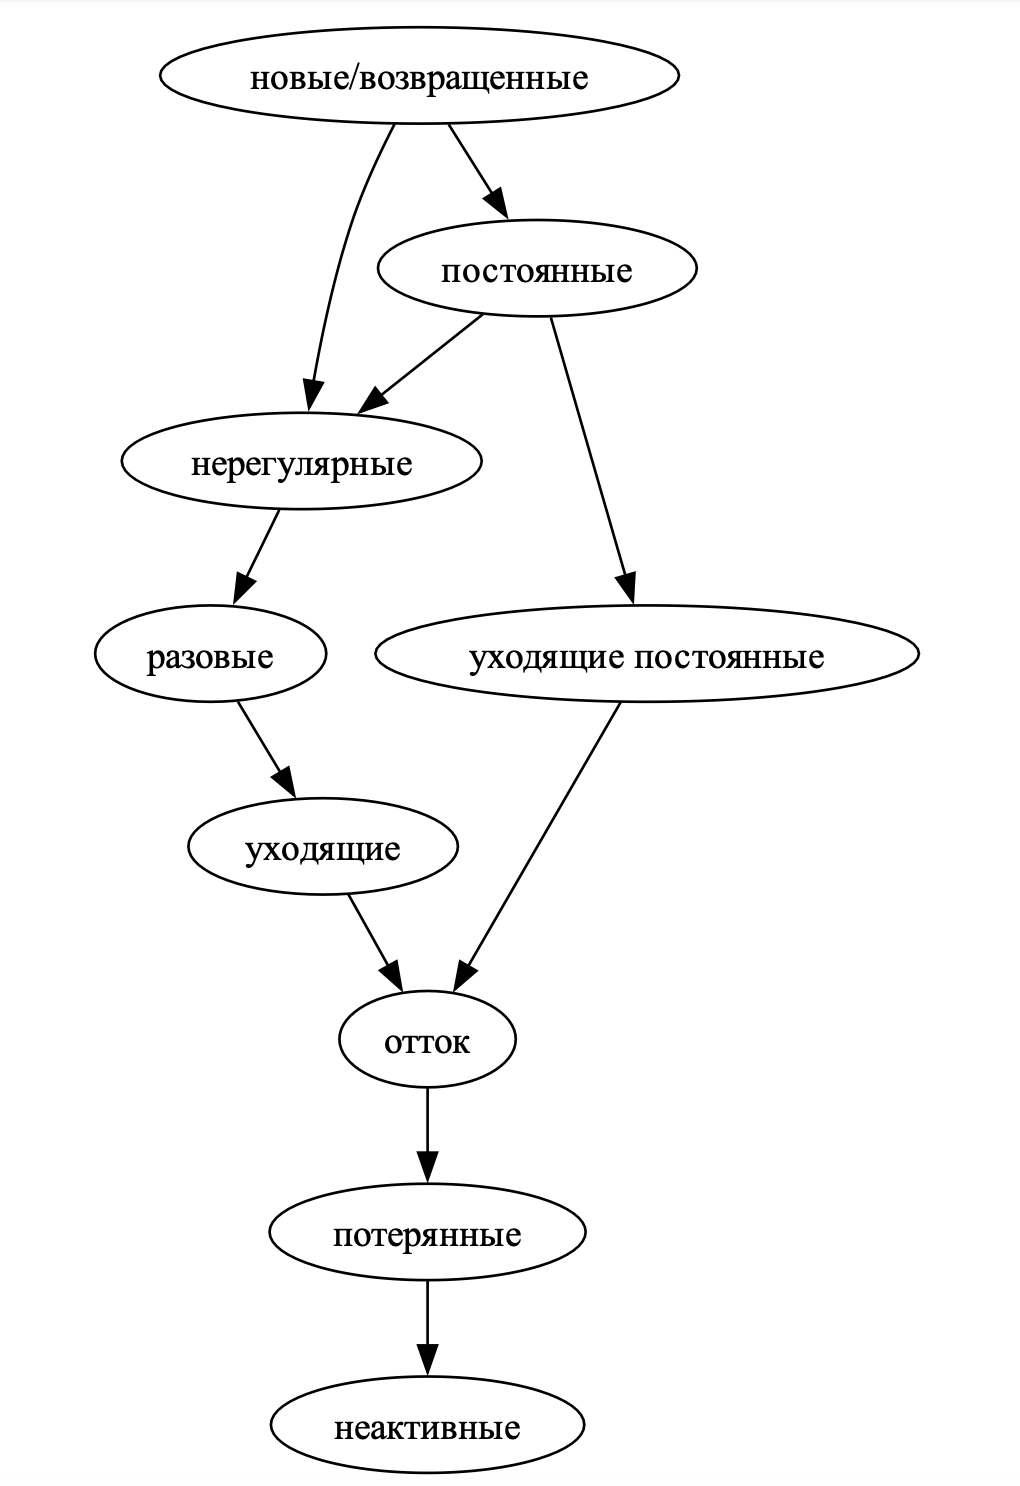


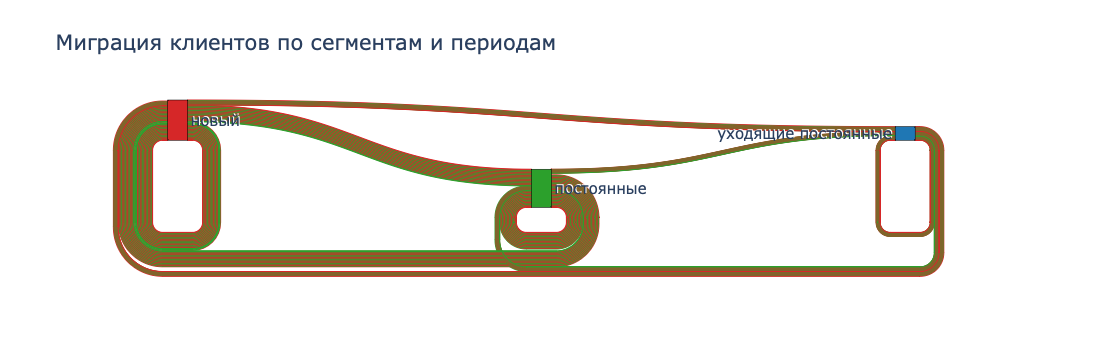

In [25]:
transition_counts = (
    transition_classified_data.groupby(["month", "detailed_status"])
    .size()
    .unstack(fill_value=0)
)

labels = sorted(set(transition_classified_data["detailed_status"]))
label_to_index = {label: i for i, label in enumerate(labels)}

sources = []
targets = []
values = []

for i in range(len(transition_counts.index) - 1):
    current_data = transition_counts.iloc[i]
    next_data = transition_counts.iloc[i + 1]
    for current_status, count in current_data.items():
        if count > 0:
            current_index = label_to_index[current_status]
            for next_status, next_count in next_data.items():
                if next_count > 0:
                    next_index = label_to_index[next_status]
                    sources.append(current_index)
                    targets.append(next_index)
                    values.append(min(count, next_count))

fig = go.Figure(
    data=[
        go.Sankey(
            node=dict(
                pad=15,
                thickness=20,
                line=dict(color="black", width=0.5),
                label=labels,
                color=['#d62728', '#2ca02c', '#1f77b4', '#ff7f0e', '#9467bd', '#8c564b'],
            link=dict(
                source=sources,
                target=targets,
                value=values,
                color=[('#d62728', '#2ca02c')[i % 2] for i in range(len(sources))]
            )
        )
    ]
)

fig.update_layout(title_text="Миграция клиентов по сегментам и периодам", font_size=15)
fig.show()

In [11]:
pivot_table = transition_classified_data.pivot_table(
    index="month", columns="detailed_status", aggfunc="size", fill_value=0
)
pivot_table.rename_axis("month", axis="columns", inplace=True)
pivot_table.index.name = None
pivot_table.rename(columns={"новый": "новые/возвращенные"}, inplace=True)
pivot_table

month,новые/возвращенные,постоянные,уходящие постоянные
2021-12,12954,0,0
2022-01,18387,0,0
2022-02,10955,0,8838
2022-03,9749,7674,2545
2022-04,8286,8406,2102
2022-05,8073,8636,1882
2022-06,8429,8557,1827
2022-07,8438,8431,2027
2022-08,8795,8396,2026
2022-09,8520,8359,2128


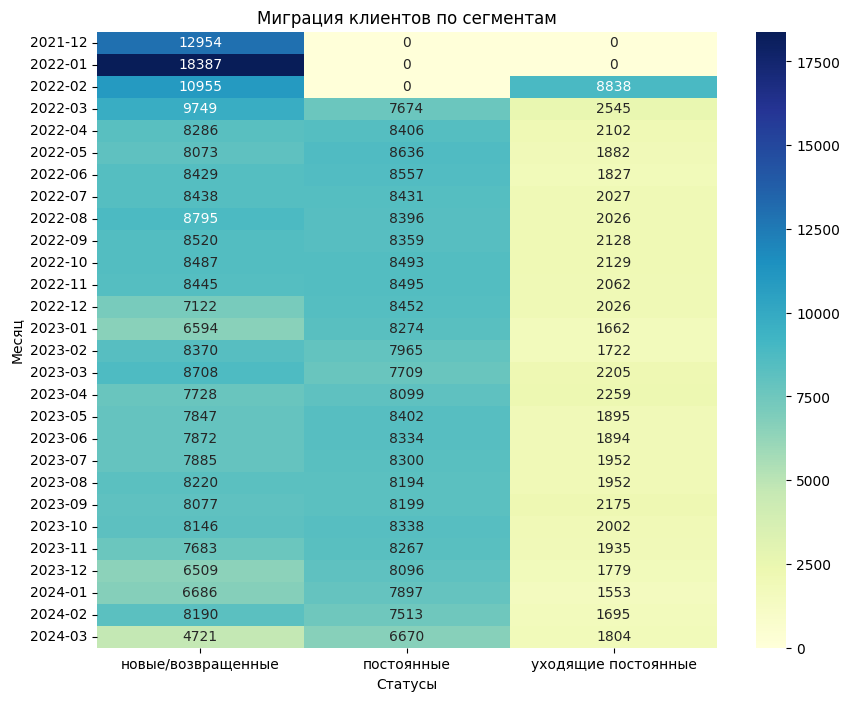

In [18]:
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu", fmt="d")
plt.title("Миграция клиентов по сегментам")
plt.xlabel("Статусы")
plt.ylabel("Месяц")
plt.show()

In [13]:
start_forecast = "2024-04"
forecast_months = pd.date_range(start=start_forecast, periods=6, freq="M")

last_known_value_date = pd.to_datetime("2024-03")
last_known_value = pivot_table.loc[last_known_value_date, "новые/возвращенные"]

forecast_values = [
    last_known_value * (1 + 0.05) ** i for i in range(len(forecast_months))
]

forecast_df = pd.DataFrame(
    {
        "month": forecast_months,
        "новые/возвращенные": forecast_values,
        "постоянные": [np.nan] * len(forecast_months),
        "нерегулярные": [np.nan] * len(forecast_months),
    }
).set_index("month")

result_df = pd.concat([pivot_table, forecast_df], sort=False)

print(result_df)

                     новые/возвращенные  постоянные  уходящие постоянные  \
2021-12                    12954.000000         0.0                  0.0   
2022-01                    18387.000000         0.0                  0.0   
2022-02                    10955.000000         0.0               8838.0   
2022-03                     9749.000000      7674.0               2545.0   
2022-04                     8286.000000      8406.0               2102.0   
2022-05                     8073.000000      8636.0               1882.0   
2022-06                     8429.000000      8557.0               1827.0   
2022-07                     8438.000000      8431.0               2027.0   
2022-08                     8795.000000      8396.0               2026.0   
2022-09                     8520.000000      8359.0               2128.0   
2022-10                     8487.000000      8493.0               2129.0   
2022-11                     8445.000000      8495.0               2062.0   
2022-12     

/var/folders/wx/t_ps87396x57bwpc30093rch0000gn/T/ipykernel_52886/2397972612.py:2: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



/Users/holodkovaelizavetaigorevna/PycharmProjects/test/.venv/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/Users/holodkovaelizavetaigorevna/PycharmProjects/test/.venv/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



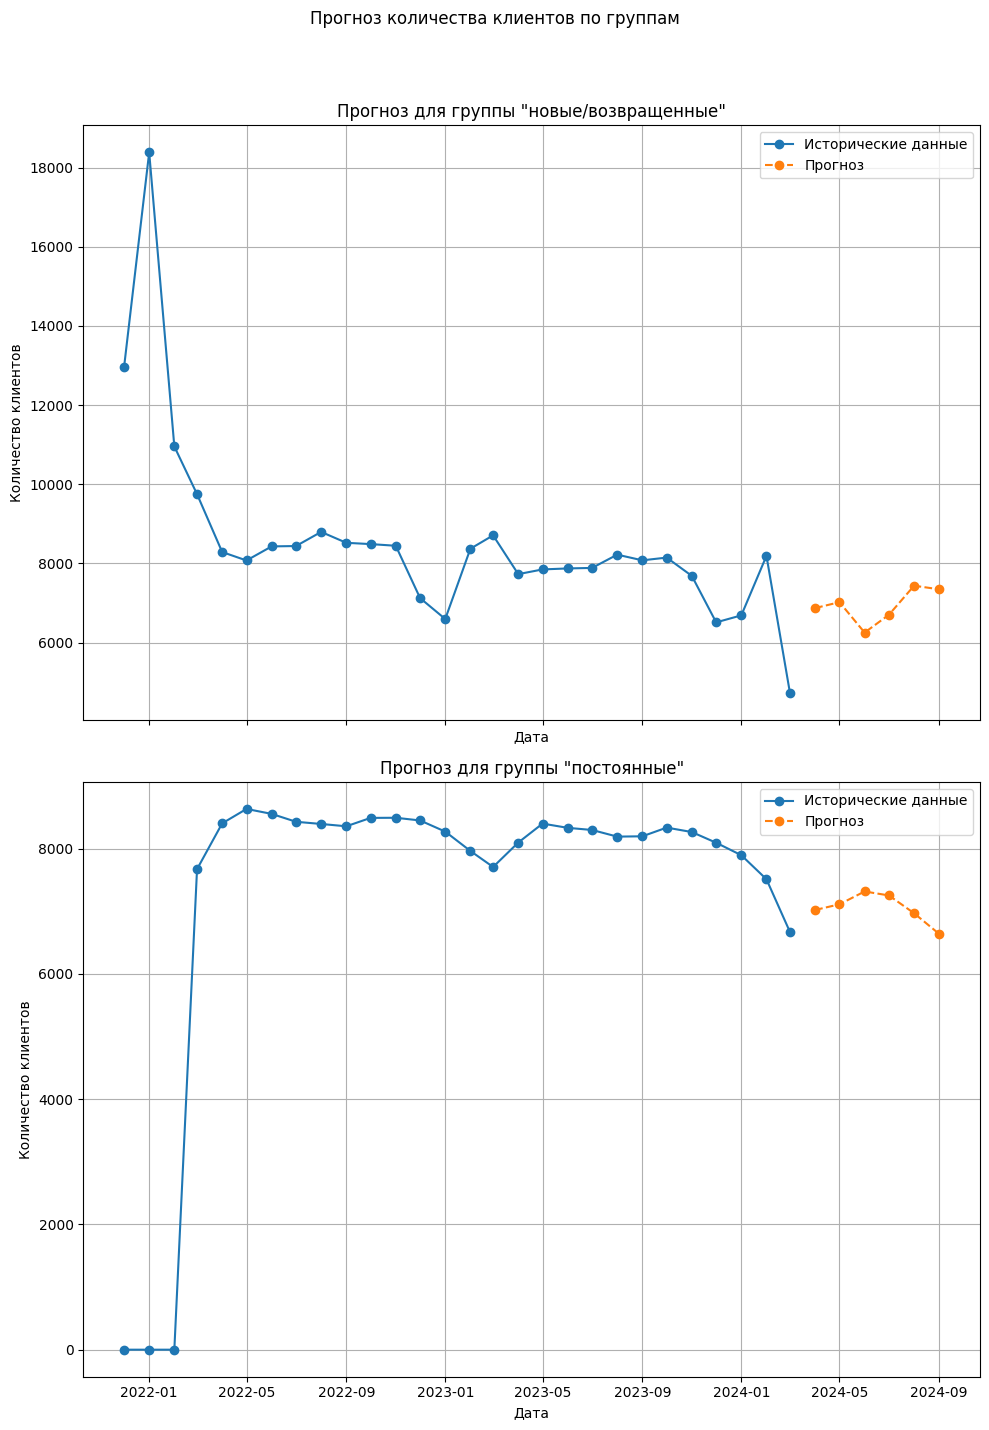

In [14]:
groups = ["новые/возвращенные", "постоянные"]
results = {}

for group in groups:
    data = pivot_table[group].dropna()

    if data.min() <= 0:
        model = ExponentialSmoothing(
            data, seasonal="add", seasonal_periods=12, initialization_method="estimated"
        ).fit()
    else:
        model = ExponentialSmoothing(
            data, seasonal="mul", seasonal_periods=12, initialization_method="estimated"
        ).fit()

    results[group] = model.forecast(6)

fig, axes = plt.subplots(nrows=len(results), ncols=1, figsize=(10, 15), sharex=True)
fig.suptitle("Прогноз количества клиентов по группам")

for ax, (group, forecast) in zip(axes, results.items()):
    historical_data = pivot_table[group].dropna()

    if isinstance(historical_data.index, pd.PeriodIndex):
        historical_data.index = historical_data.index.to_timestamp()

    ax.plot(
        historical_data.index,
        historical_data,
        label="Исторические данные",
        marker="o",
        linestyle="-",
    )

    forecast.index = forecast.index.to_timestamp()

    ax.plot(forecast.index, forecast, label="Прогноз", marker="o", linestyle="--")
    ax.set_title(f'Прогноз для группы "{group}"')
    ax.set_xlabel("Дата")
    ax.set_ylabel("Количество клиентов")
    ax.legend()
    ax.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

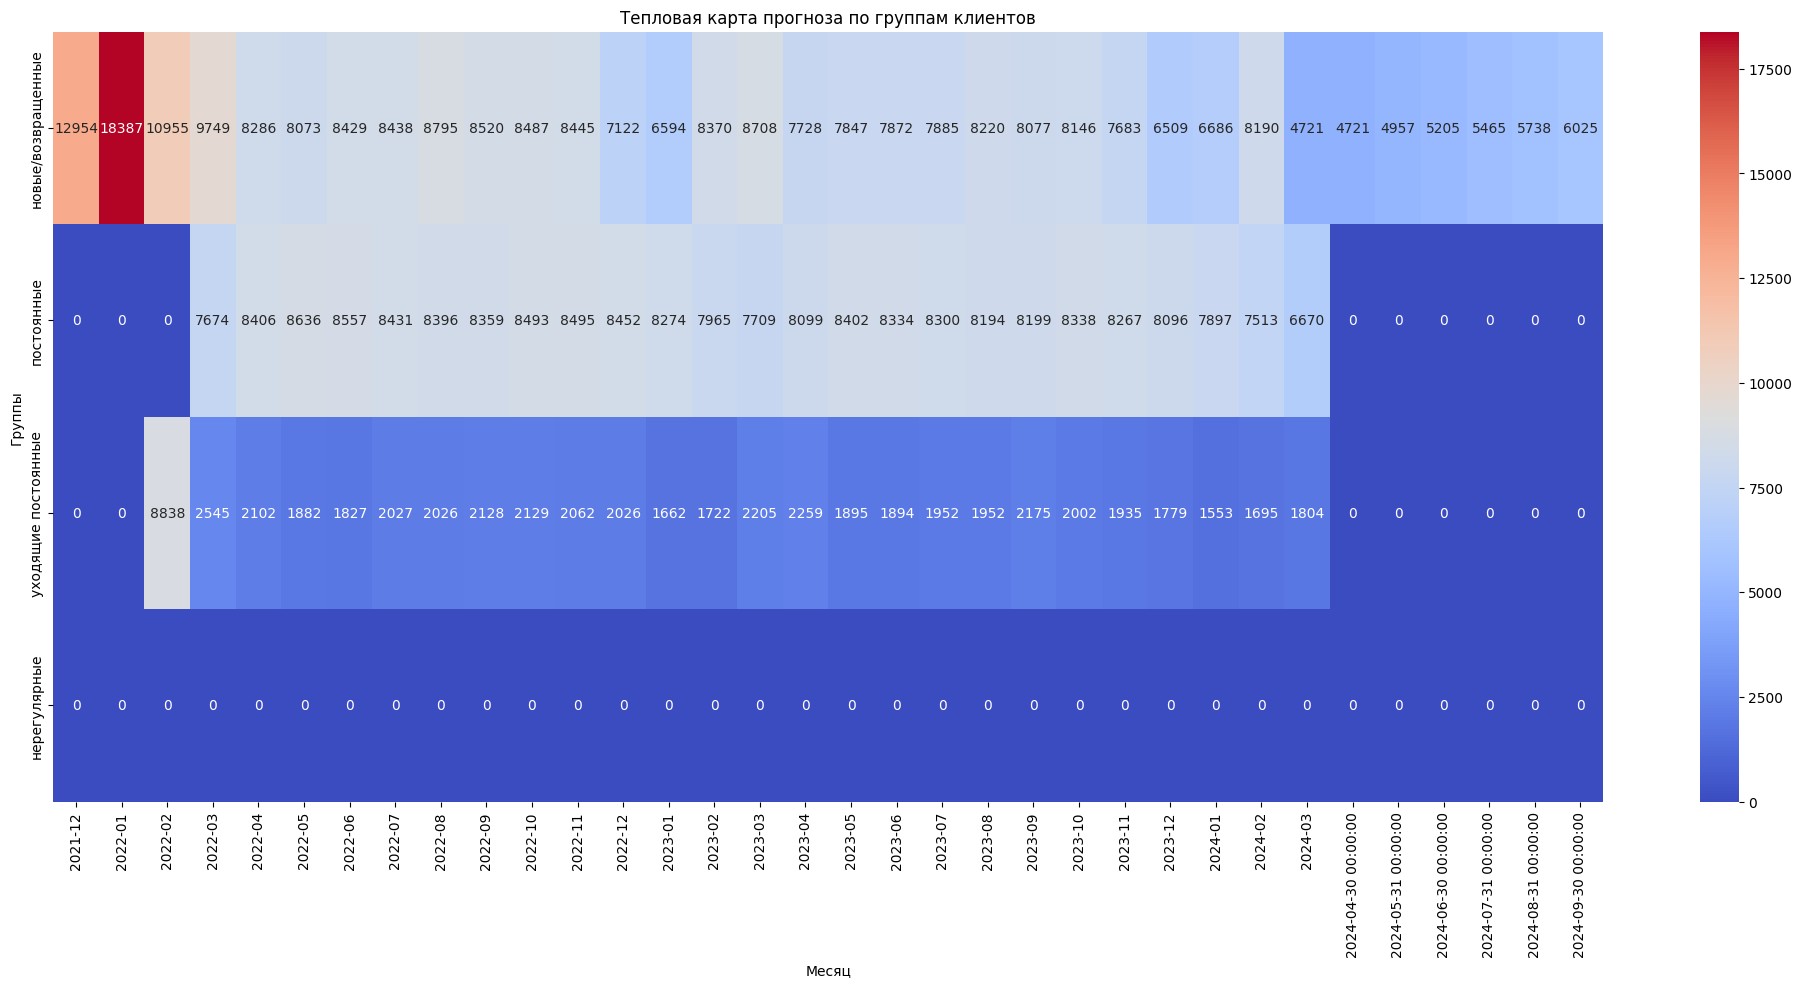

In [15]:
complete_data = pd.concat([pivot_table, forecast_df], sort=False).fillna(0)

plt.figure(figsize=(25, 10))
sns.heatmap(complete_data.T, cmap="coolwarm", annot=True, fmt=".0f")
plt.title("Тепловая карта прогноза по группам клиентов")
plt.xlabel("Месяц")
plt.ylabel("Группы")
plt.show()

In [16]:
groups = ["новые/возвращенные", "постоянные"]
results = {}

for group in groups:
    data = pivot_table[group].fillna(pivot_table[group].mean())

    if data.min() <= 0:
        model = ExponentialSmoothing(
            data, seasonal="add", seasonal_periods=12, initialization_method="estimated"
        ).fit()
    else:
        model = ExponentialSmoothing(
            data, seasonal="mul", seasonal_periods=12, initialization_method="estimated"
        ).fit()

    forecast = model.forecast(6)

    results[group] = forecast

for group, forecast in results.items():
    print(f"Прогноз для {group}:")
    print(forecast)
    print("\n")

Прогноз для новые/возвращенные:
2024-04    6870.274589
2024-05    7019.298249
2024-06    6250.799434
2024-07    6701.649644
2024-08    7435.464084
2024-09    7344.127164
Freq: M, dtype: float64


Прогноз для постоянные:
2024-04    7022.431041
2024-05    7112.992482
2024-06    7318.084561
2024-07    7254.371354
2024-08    6969.968969
2024-09    6638.744168
Freq: M, dtype: float64




/Users/holodkovaelizavetaigorevna/PycharmProjects/test/.venv/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/Users/holodkovaelizavetaigorevna/PycharmProjects/test/.venv/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

